# Value at Risk (VaR) and Expected Shortfall (ES) Calculation

### Background on VaR and ES

#### VaR
https://www.risk.net/definition/value-at-risk-var

#### ES
https://www.risk.net/definition/expected-shortfall

#### Difference between VaR and ES
https://www.risk.net/risk-magazine/technical-paper/1506669/var-versus-expected-shortfall

### Setup

Note: yfinance api is used here since it is widely used and free, and most importantly with datetime package we can roll the program daily and calculate the risk measure automatically

In [8]:
# import necessary packages

# import statistical packages
import pandas as pd
import numpy as np
from scipy.stats import norm
from arch import arch_model

# import api datasource
import yfinance as yf

# import date calculation package
from datetime import datetime, timedelta

# import visualisation packages
import matplotlib.pyplot as plt
import matplotlib as mpl

# warning exception handling
pd.options.mode.chained_assignment = None

# some customisation could be used if needed
# plt.style.use('seaborn-v0_8-dark-palette')
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#8DC2DF', '#003A79', '#ECBD00', '#006C24', '#EC6400'])

### Input

#### Here we can input the any ticker as long as the ticker is available on Yahoo Finance

Example: We input 'CL=F' for NY Crude Oil Dec 23 Futures Contract
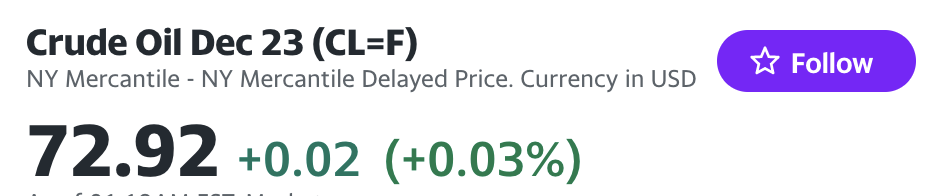

#### Alpha is adjustable here and normally we input 0.05, 0.25 and 0.01 for 95%, 97.5% and 99% confidence level respectively

In [15]:
# Define the ticker symbol for the stock you want to analyze
symbol = 'CL=F'

# Define the parameters for VaR calculation
alpha = 0.05
confidence_level = 1 - alpha

VaR and ES are usually taken at 1-year timeframe for calculation, so the days equal to 365

In [16]:
# Download historical data using yfinance
start_date = datetime.today() - timedelta(days=365)
end_date = datetime.today() - timedelta(days=1)
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


Generalised AutoRegressive Conditional Heteroskedasticity (GARCH) model used here is a popular model to forecast the volatility, and we used the modelled returns and volatilities to estimate the VaR

In [17]:
# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change().dropna()
data = data.tail(-1)

# Calculate mean of daily returns and standard deviation
returns_mean = data['Returns'].mean()
returns_std = data['Returns'].std()

# Calculate filtered returns and VaR using GARCH model
model = arch_model(data['Returns'], vol='Garch', p=1, q=1, rescale=False)
result = model.fit(update_freq=5)
data['FilteredReturns'] = -data['Returns'] / result.conditional_volatility / 100
data['GARCHVaR'] = result.conditional_volatility * data['FilteredReturns'].quantile(alpha) * 100

Iteration:      5,   Func. Count:     40,   Neg. LLF: -605.2375741822283
Iteration:     10,   Func. Count:     70,   Neg. LLF: -607.5261546696099
Optimization terminated successfully    (Exit mode 0)
            Current function value: -607.5262250376405
            Iterations: 11
            Function evaluations: 87
            Gradient evaluations: 11


Here we calculated the ES and a simplified stressed ES for demonstration purpose

In [18]:
# Calculate ES using historical simulation
sorted_returns = data['Returns'].sort_values(ascending=True)
index = int(confidence_level * len(sorted_returns))
data['ES'] = sorted_returns[:index].mean() * 100

# Calculate stressed ES
stress_factor = 1.5
risk_weight = 2.0
data['StressedES'] = data['ES'] * stress_factor

And finally, we plot the histograms of modelled returns, normal distrbution line and risk measures

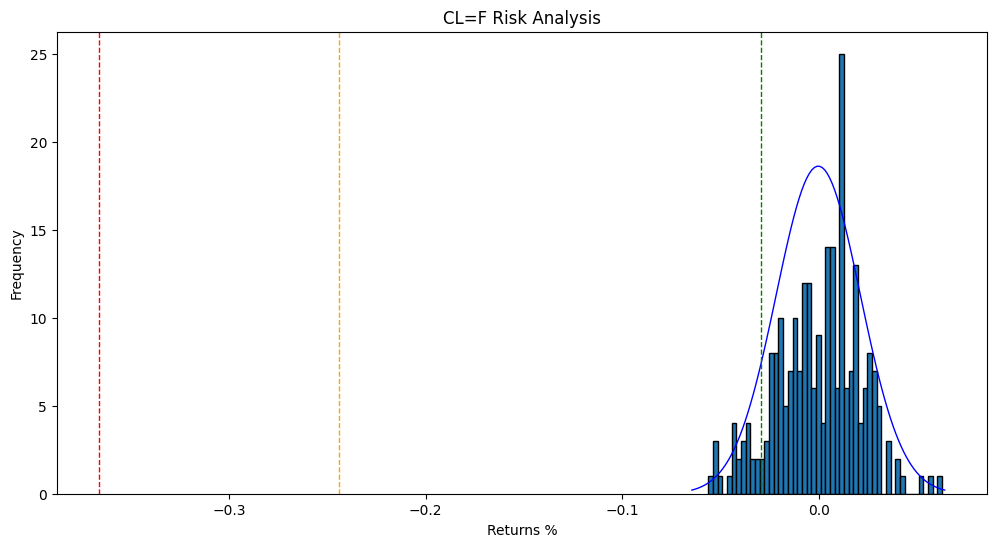

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate returns histogram
returns_hist = plt.hist(data['Returns'], bins=50, edgecolor='black', linewidth=1)

# Plot normal distribution line
x = np.linspace(returns_mean - 3 * returns_std, returns_mean + 3 * returns_std, 100)
y = norm.pdf(x, returns_mean, returns_std)
ax.plot(x, y, color='blue', linewidth=1)

# Plot vertical lines for risk measures
plt.axvline(data['GARCHVaR'].iloc[-1], color='green', linestyle='--', linewidth=1)
plt.axvline(data['ES'].iloc[-1], color='orange', linestyle='--', linewidth=1)
plt.axvline(data['StressedES'].iloc[-1], color='red', linestyle='--', linewidth=1)

# Customize the plot
plt.title(f'{symbol} Risk Analysis')
plt.xlabel('Returns %')
plt.ylabel('Frequency')

plt.show()

#### Interpertation of the visualisation

Green line = VaR
Yellow line = ES
Red line = Simplified Stressed ES

The visualisation will show the approximate risks from each risk measure. For the precise VaR amount, the below summary will conclude the risk amount in dollar terms in VaR and ES

In [43]:
VaR_amount = data['GARCHVaR'][-1] * data['Adj Close'][-1]

print(f'There is {confidence_level*100}% confidence, that over the coming 365 days the {symbol} will not lose more than {-VaR_amount}')

There is 95.0% confidence, that over the coming 365 days the CL=F will not lose more than 2.1379702109540344


In [44]:
ES_amount = data['ES'][-1] * data['Adj Close'][-1]

print(f'There is {confidence_level*100}% confidence, that over the coming 365 days the {symbol} will not lose more than {-ES_amount}')

There is 95.0% confidence, that over the coming 365 days the CL=F will not lose more than 17.794928145319478
